In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.optimize import curve_fit

# 連続NDフィルタ

NDL-10C-2

https://www.thorlabs.co.jp/newgrouppage9.cfm?objectgroup_id=1623&pn=NDL-10C-2

$$
    T:透過率 \quad OD:光学濃度 \\
    OD = \log_{10} (\frac{1}{T}) \quad or \quad T = 10^{-OD}
$$


In [2]:
def optical_density(length):
    """
    length: mm
    """
    if length <= 5:
        return 0
    elif length <= 50:
        return (length-5) * 2 / 45
    else:
        return 2

In [3]:
def transmisson(od):
    """
    od: optical density
    """
    return 10 ** (-od)

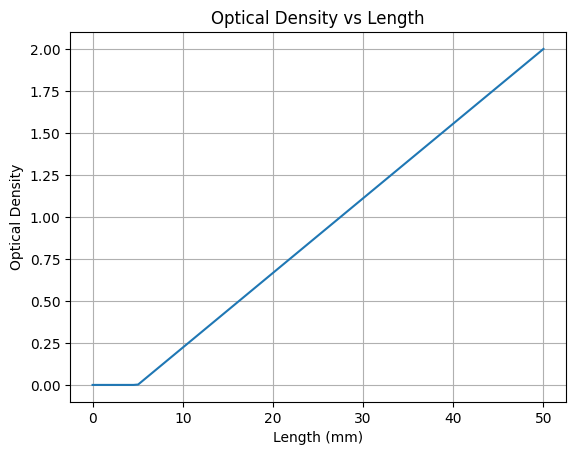

In [4]:
xlist = np.linspace(0, 50, 100)
ylist = [optical_density(x) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Length (mm)")
plt.ylabel("Optical Density")
plt.title("Optical Density vs Length")
plt.grid()
plt.show()

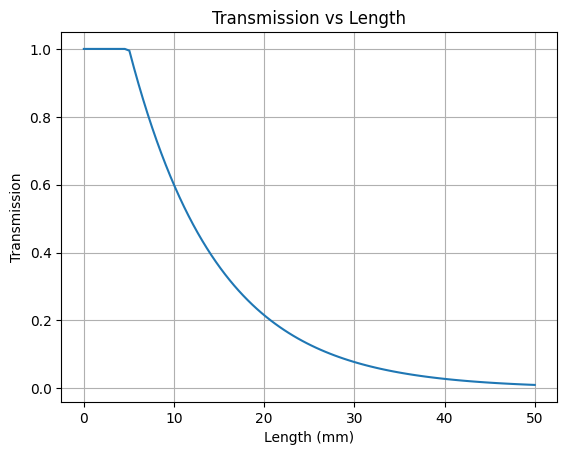

In [5]:
xlist = np.linspace(0, 50, 100)
ylist = [transmisson(optical_density(x)) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Length (mm)")
plt.ylabel("Transmission")
plt.title("Transmission vs Length")
plt.grid()
plt.show()

### ビームスプリッタを考慮したモデル

In [6]:
splitratio = 0.92

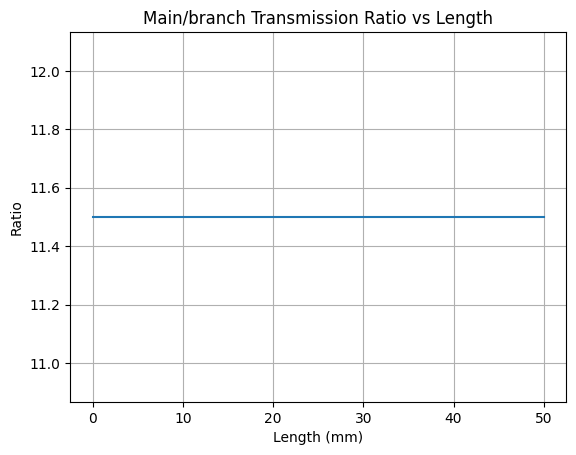

In [7]:
xlist = np.linspace(0, 50, 100)
ylist = [transmisson(optical_density(x)) for x in xlist]
main = [y * splitratio for y in ylist]
branch = [y * (1 - splitratio) for y in ylist]
ratio = [m/b for m, b in zip(main, branch)]
plt.plot(xlist, ratio)
plt.xlabel("Length (mm)")
plt.ylabel("Ratio")
plt.title("Main/branch Transmission Ratio vs Length")
plt.grid()
plt.show()

# パワーメータによる実際の計測データの可視化

In [8]:
lengthlist = [561, 633, 785]

In [9]:
dfdict = {}
for length in lengthlist:
    tempdata =  pl.read_csv(f"../data/{length}.csv", has_header=True)
    for col in tempdata.columns:#convert from W to mW
        if col == "step" or "ratio" in col:
            continue
        tempdata = tempdata.with_columns(tempdata[col] * 1000)
    groupdata = tempdata.group_by("step").agg(
        pl.mean("handy-end").name.suffix("_mean"),
        pl.std("handy-end").name.suffix("_std"),
        pl.mean("handy-mid").name.suffix("_mean"),
        pl.std("handy-mid").name.suffix("_std"),
        pl.mean("set").name.suffix("_mean"),
        pl.std("set").name.suffix("_std"),
    )
    groupdata = groupdata.sort("step")
    groupdata = groupdata.with_columns((groupdata["handy-end_mean"] / groupdata["handy-mid_mean"]).alias("ratio_h2h_mean"))
    groupdata = groupdata.with_columns((groupdata["handy-end_mean"] / groupdata["set_mean"]).alias("ratio_h2s_mean"))
    groupdata = groupdata.with_columns(ratio_h2h_std = groupdata["ratio_h2h_mean"] * (groupdata["handy-end_std"] / groupdata["handy-end_mean"] + groupdata["handy-mid_std"] / groupdata["handy-mid_mean"]))
    groupdata = groupdata.with_columns(ratio_h2s_std = groupdata["ratio_h2s_mean"] * (groupdata["handy-end_std"] / groupdata["handy-end_mean"] + groupdata["set_std"] / groupdata["set_mean"]))
    dfdict[length] = groupdata

In [10]:
def plotdata(df, length):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.plot(df["step"], df[f"handy-end_mean"], label="handy-end", color="red")
    ax1.errorbar(df["step"], df[f"handy-end_mean"], yerr=df[f"handy-end_std"], fmt='o', capsize=5, color="red", markerfacecolor='none')

    ax1.plot(df["step"], df[f"handy-mid_mean"], label="handy-mid", color="blue")
    ax1.errorbar(df["step"], df[f"handy-mid_mean"], yerr=df[f"handy-mid_std"], fmt='o', capsize=5, color="blue", markerfacecolor='none')
    
    ax1.plot(df["step"], df[f"set_mean"], label="set", color="green")
    ax1.errorbar(df["step"], df[f"set_mean"], yerr=df[f"set_std"], fmt='o', capsize=5, color="green", markerfacecolor='none')
    ax1.set_ylim(0, 5.0)

    ax2 = ax1.twinx()
    ax2.plot(df["step"], df["ratio_h2h_mean"], label="ratio_h2h", color="black")
    ax2.errorbar(df["step"], df["ratio_h2h_mean"], yerr=df["ratio_h2h_std"], fmt='o', capsize=5, color="black", markerfacecolor='none')
    """
    ax2.plot(df["step"], df["ratio_h2s_mean"], label="ratio_h2s", color="orange")
    ax2.errorbar(df["step"], df["ratio_h2s_mean"], yerr=df["ratio_h2s_std"], fmt='o', capsize=5, color="orange", markerfacecolor='none')
    """
    ax2.set_ylim(0, 7.0)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper right')

    ax1.set_ylabel("power[mW]")
    ax2.set_ylabel("Ratio")
    ax1.set_xlabel("Step")

    plt.title(f"Length: {length} mm")

    plt.show()

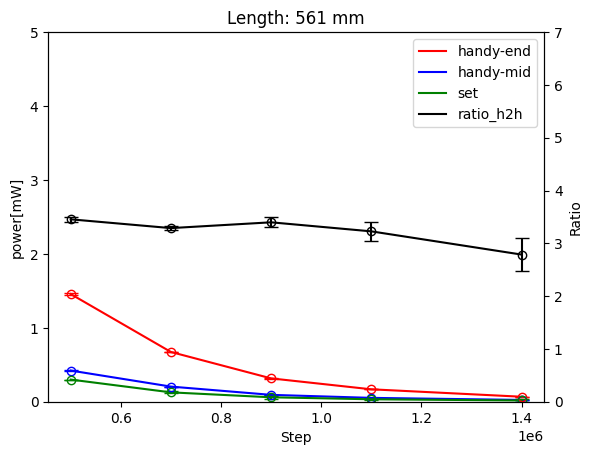

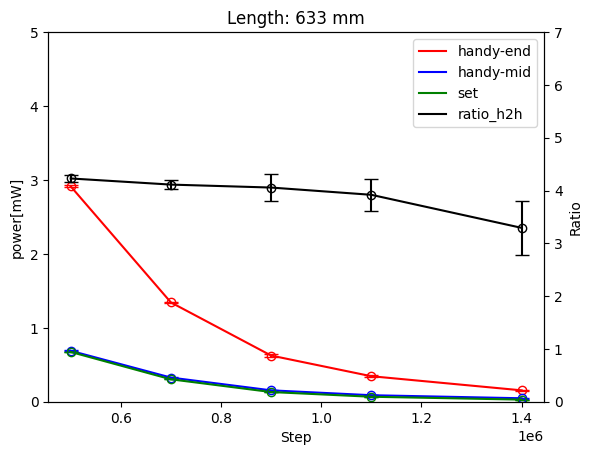

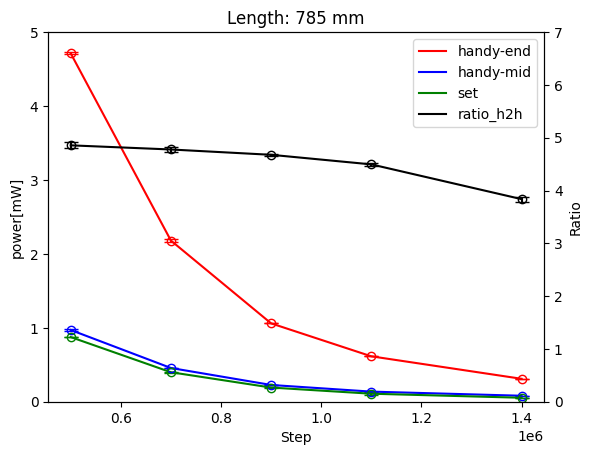

In [11]:
for length in lengthlist:
    plotdata(dfdict[length], length)

波長依存性ないかも

In [12]:
plt.close()

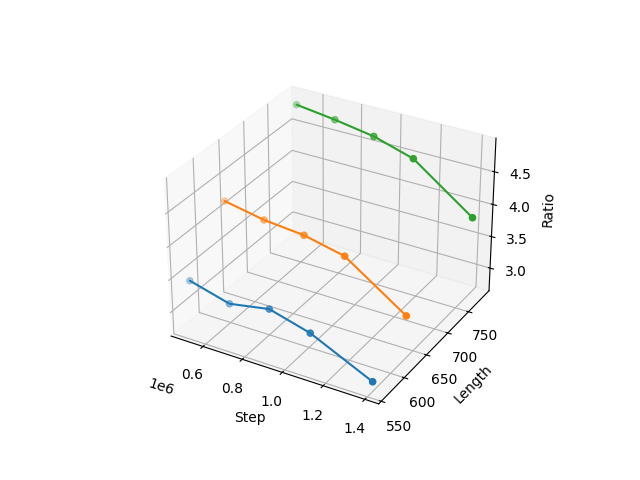

In [13]:
%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("Step")
ax.set_ylabel("Length")
ax.set_zlabel("Ratio")
for length in lengthlist:
    pass
    ax.plot(dfdict[length]["step"], [length] * len(dfdict[length]), dfdict[length]["ratio_h2h_mean"])
    ax.scatter(dfdict[length]["step"], [length] * len(dfdict[length]), dfdict[length]["ratio_h2h_mean"])
plt.show()

# フィッティング

In [16]:

plt.close()

In [17]:
%matplotlib inline

In [18]:
def func(x, a, b, c, d):
    return -1 * a * np.exp(b * (x-c)) + d

In [19]:
def linear(x, a, b, c, d):
    return a * np.log(b * (x-c)) +d

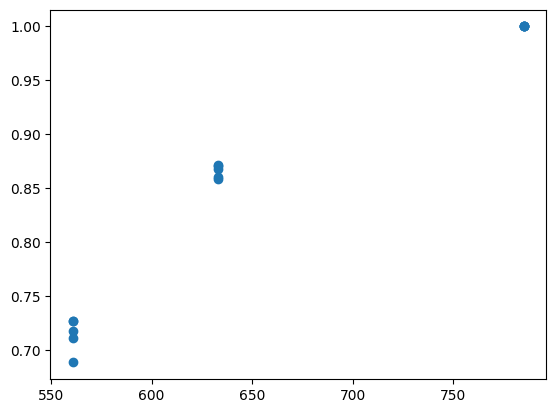

In [20]:
xlist = []
ylist = []
for length in [561, 633]:
    xlist.append([length for _ in range(len(dfdict[length]["step"]))])
    ylist.append(dfdict[length]["ratio_h2h_mean"]/dfdict[785]["ratio_h2h_mean"])
xlist.append([785 for _ in range(len(dfdict[785]["step"]))])
ylist.append(dfdict[785]["ratio_h2h_mean"]/dfdict[785]["ratio_h2h_mean"])
plt.scatter(xlist, ylist)
plt.show()

C:\Users\kouga\AppData\Local\Temp\ipykernel_11248\2588690326.py:2: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * (x-c)) +d


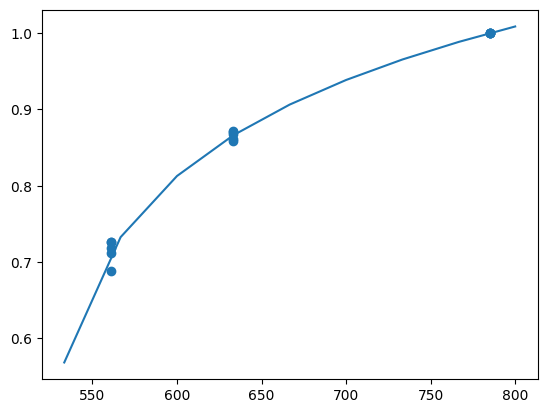

[1.62850538e-01 4.80427255e-01 5.14203755e+02 2.07196791e-01]


In [21]:
lpopt, _ = curve_fit(linear, np.array(xlist).flatten(), np.array(ylist).flatten(), p0=[0.05, 300, 550, 0.6])
plt.scatter(xlist, ylist)
xpl = np.linspace(500, 800, 10)
plt.plot(xpl, linear(xpl, *lpopt))
plt.show()
print(lpopt)

[7.77263496e-01 3.45229002e-06 1.32827965e+06 4.86291339e+00]


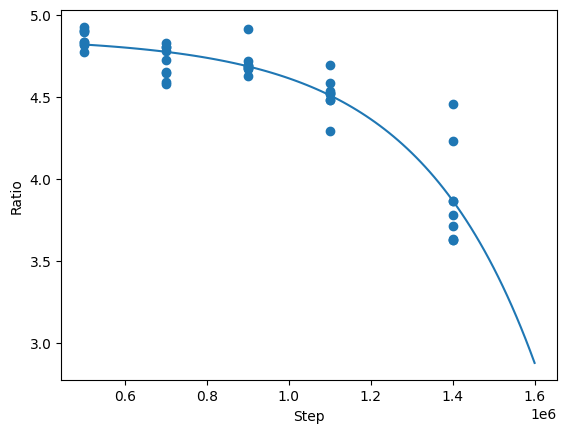

In [22]:
data = None
for idx, length in enumerate(lengthlist):

    df = pl.read_csv(f"../data/{length}.csv", has_header=True)

    if idx == 0:
        df = df.select("step", "ratio")
        data = df.with_columns(df["ratio"] / linear(length, *lpopt))
    else:
        df = df.with_columns(df["ratio"] / linear(length, *lpopt))
        data = pl.concat([data, df.select("step", "ratio")])

step = data["step"].to_numpy().astype(np.float64)
ratio = data["ratio"].to_numpy().astype(np.float64)


plt.scatter(step, ratio)
p0 = [0.5, 0.5e-5, 7, 5]
popt, pcov = curve_fit(func, step, ratio, p0=p0)
print(popt)
xlist = np.linspace(5e5, 16e5, 100)
plt.plot(xlist, func(xlist, *popt))
plt.xlabel("Step")
plt.ylabel("Ratio")
plt.show()

$$
    A(\lambda) = \\
    R(s) = -7.77 exp(3.5e-6(x-1.32e6))+4.8 \\

    R_{modified}(s) = A(\lambda) R(s)

    R^-1_{modified}(r) = R^-1 (r / A(\lambda))
$$

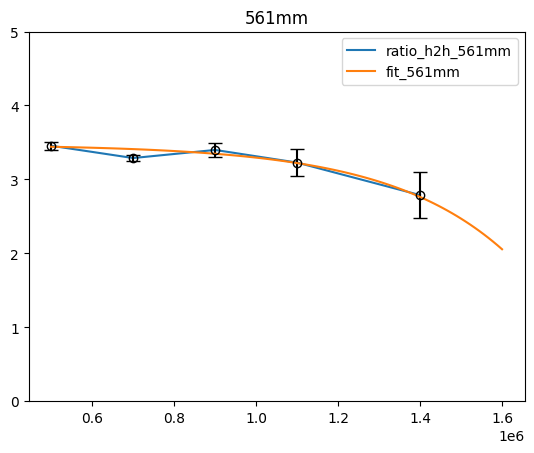

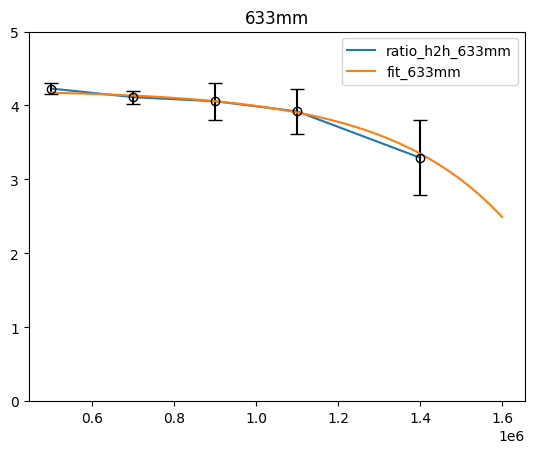

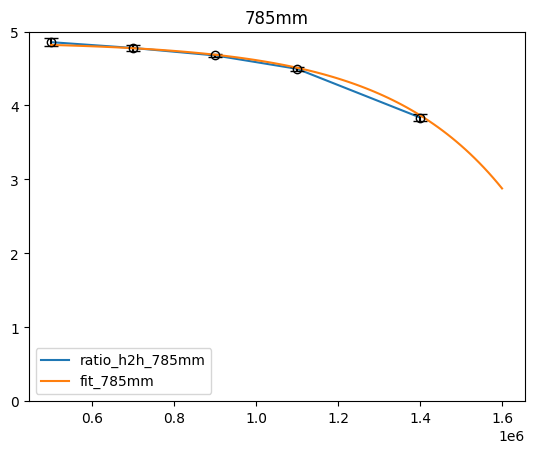

In [23]:
for length in lengthlist:
    df = dfdict[length]
    plt.plot(df["step"], df["ratio_h2h_mean"], label=f"ratio_h2h_{length}mm")
    plt.errorbar(df["step"], df["ratio_h2h_mean"], yerr=df["ratio_h2h_std"], fmt='o', capsize=5, color="black", markerfacecolor='none')
    xpl = np.linspace(5e5, 16e5, 100)
    plt.plot(xpl, func(xpl, *popt) * linear(length, *lpopt), label=f"fit_{length}mm")
    plt.title(f"{length}mm")
    plt.ylim(0, 5.0)
    plt.legend()
    plt.show()

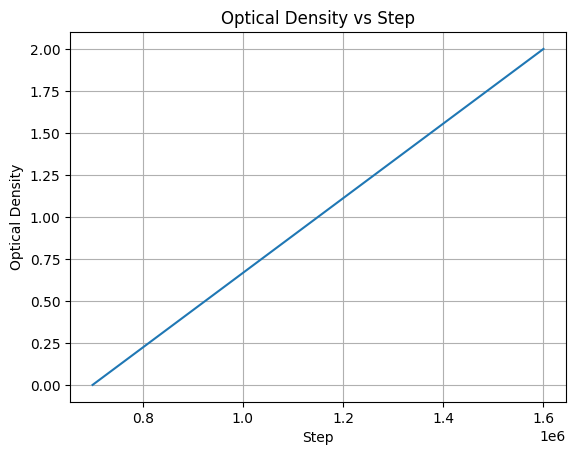

In [24]:
def optical_density_step(step):
    if step <= 1.6e6:
        return (step- 0.7e6) * 2 /0.9e6
    else:
        return 2
xlist = np.linspace(0.7e6, 1.6e6, 100)
ylist = [optical_density_step(x) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Step")
plt.ylabel("Optical Density")
plt.title("Optical Density vs Step")
plt.grid()
plt.show()

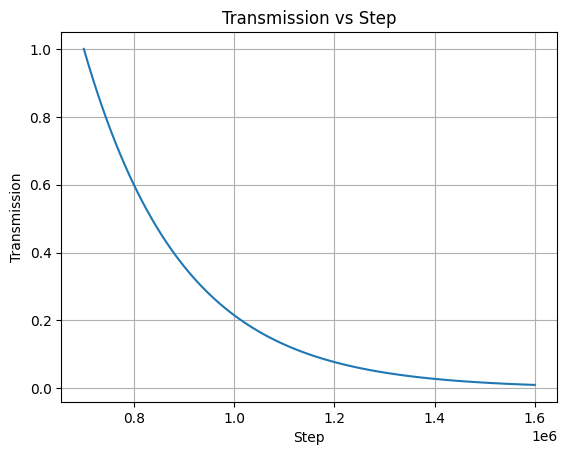

In [25]:
xlist = np.linspace(0.7e6, 1.6e6, 100)
ylist = [transmisson(optical_density_step(x)) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Step")
plt.ylabel("Transmission")
plt.title("Transmission vs Step")
plt.grid()
plt.show()

20240524_1　ここまで

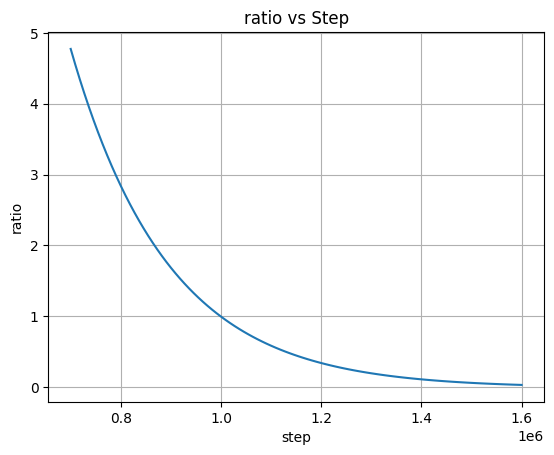

In [26]:
xlist = np.linspace(0.7e6, 1.6e6, 100)
ylist = [transmisson(optical_density_step(x)) * func(x, *popt) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("step")
plt.ylabel("ratio")
plt.title("ratio vs Step")
plt.grid()
plt.show()

In [27]:
def inverse_func(y, a, b, c, d):
    return -1 * a * np.log((y + b) / c) + d

In [28]:
opt, cov = curve_fit(inverse_func, ylist, xlist, p0=[1e6, 1,1,2e6], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
print(opt)

[1.90909955e+05 1.51746042e-02 3.01599589e-02 1.66919002e+06]


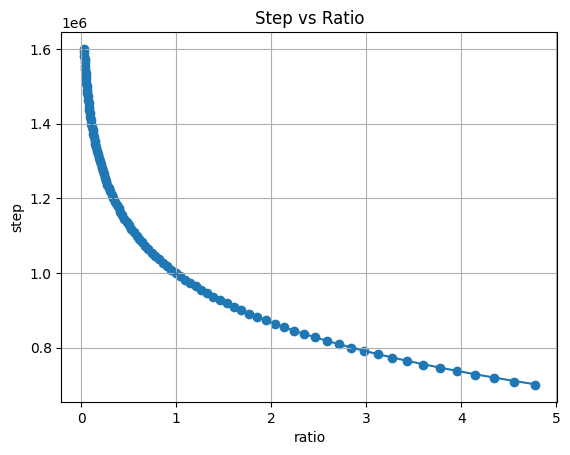

In [29]:
plt.scatter(ylist, xlist)
plt.plot(ylist, inverse_func(ylist, *opt))
plt.xlabel("ratio")
plt.ylabel("step")
plt.title("Step vs Ratio")
plt.grid()
plt.show()